In [409]:
from skimage.filters import threshold_local
from PIL import Image,ImageEnhance
import numpy as np 
import cv2
from cv2.typing import MatLike
import matplotlib.pyplot as plt

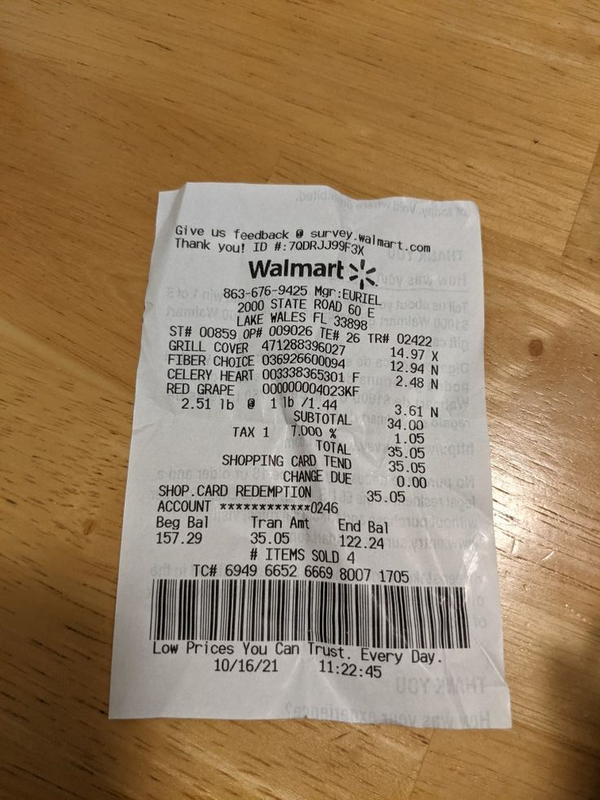

In [410]:
file_name = '../data/origin_img/19.jpg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.LANCZOS)
img

In [411]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

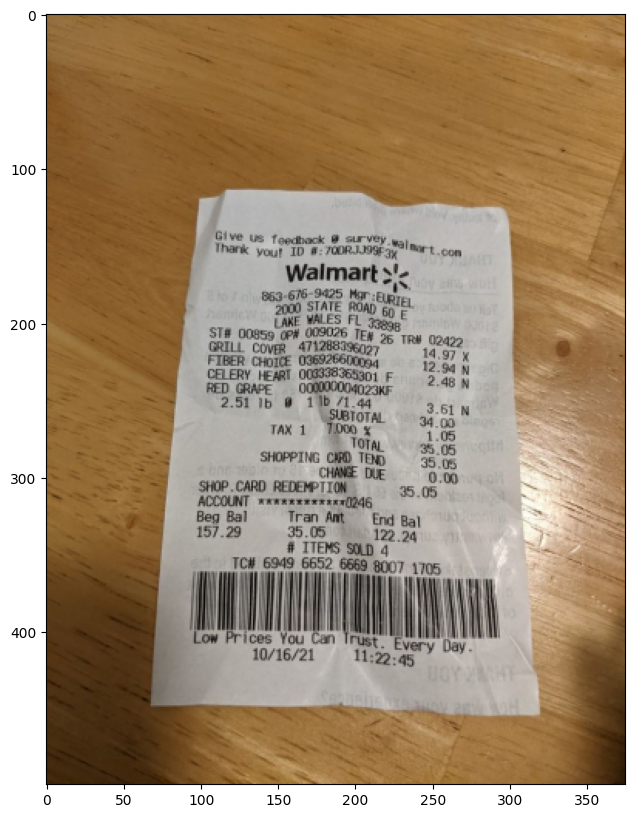

In [412]:
image = cv2.imread(file_name)
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)
plot_rgb(image)

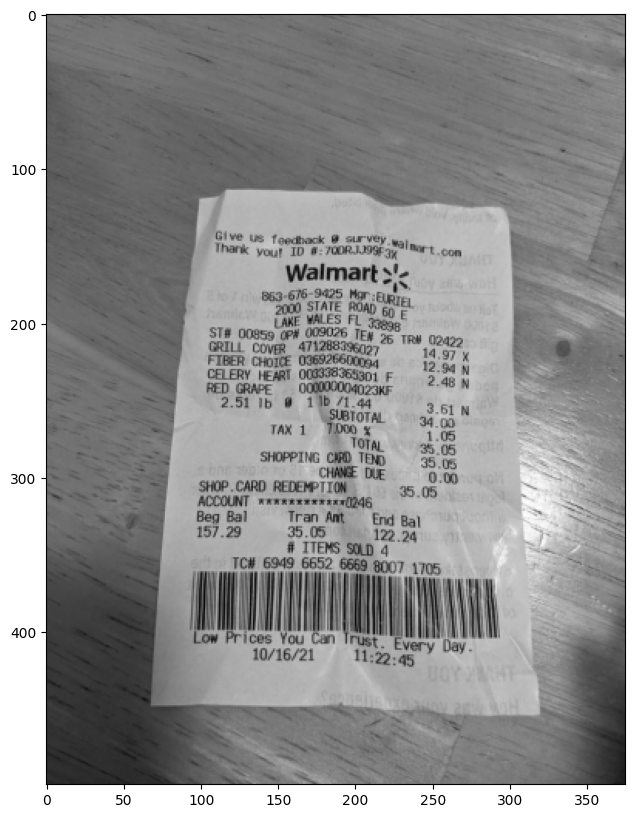

In [413]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_rgb(gray)

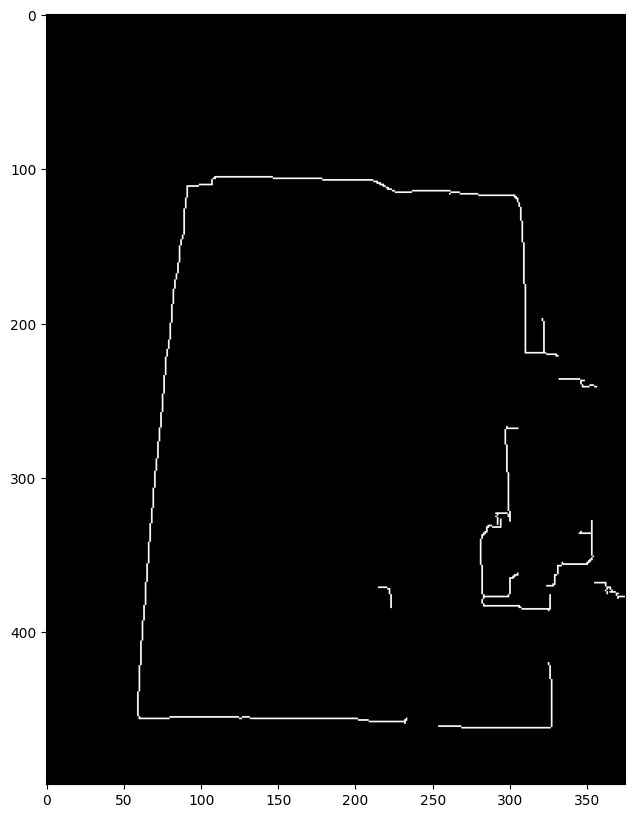

In [414]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, ( 9, 9))
dilated = cv2.dilate(blurred, rectKernel, iterations=1)
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, rectKernel)
edged = cv2.Canny(closing, 50, 200, apertureSize=3)
''''''
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
# dilated_image = cv2.dilate(
#     gray, rectKernel, iterations=2
# )  # Adjust iterations as needed
# closing = cv2.morphologyEx(dilated_image, cv2.MORPH_CLOSE, rectKernel)
# edged = cv2.Canny(closing, 50, 150)
# Human Skin Tone
'''
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
v_channel = hsv[:, :, 2]
ret, thresh = cv2.threshold(v_channel, 150, 255, cv2.THRESH_BINARY)
kernel = np.ones((5, 5), np.uint8)
edged = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
'''

plot_gray(edged)

In [415]:
contours, hierarchy = cv2.findContours(
            edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

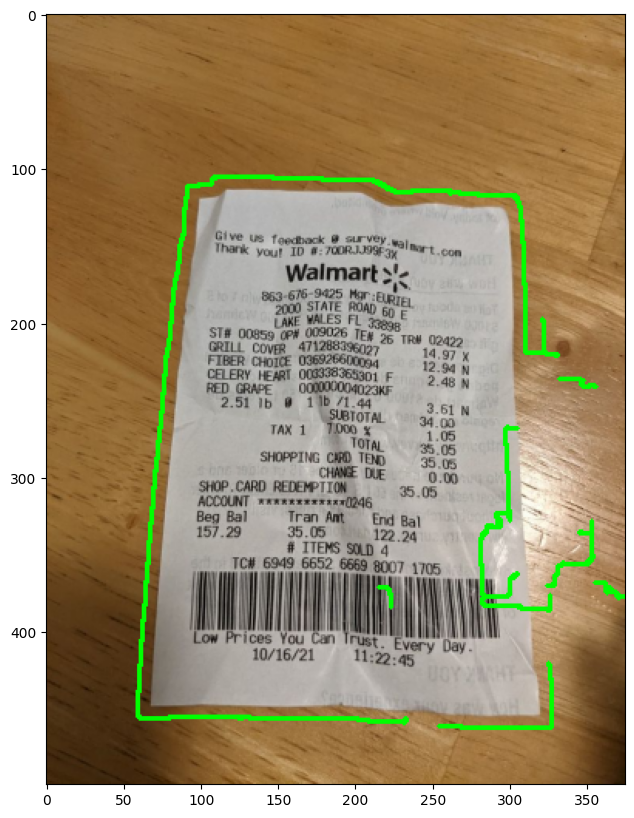

In [416]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 2)
plot_rgb(image_with_largest_contours)

In [417]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    epsilon = 0.01 * cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, epsilon, True)
def get_receipt_contour(contours):    
    for c in contours:
        approx = approximate_contour(c)
        if len(approx) == 4:
            return approx
        else:
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.intp(box)
            return approx

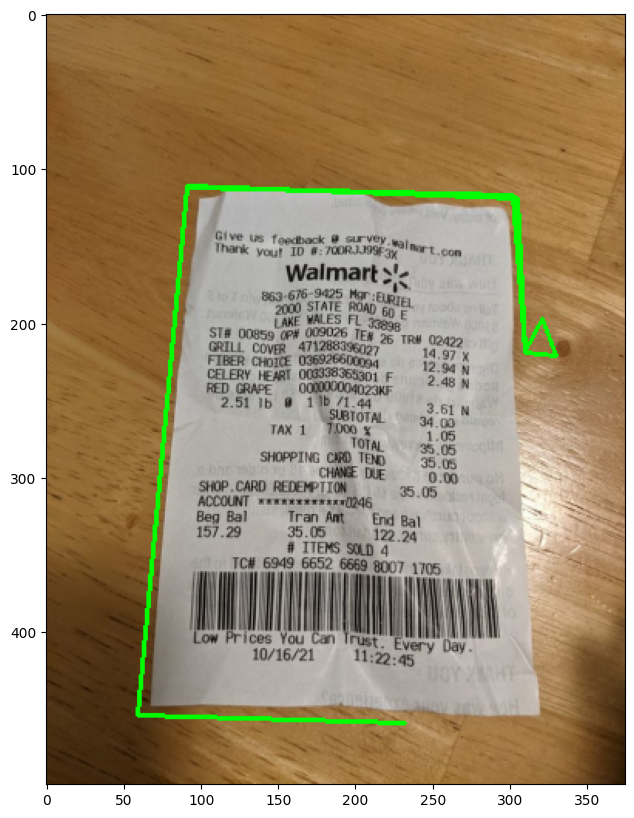

In [418]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [419]:
def contour_to_rect(contour):
    x, y, w, h = cv2.boundingRect(contour)
    rect_points = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]])

    pts = rect_points.reshape(4, 2, order='F')
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio
    
def wrap_perspective(img, rect) -> MatLike:
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

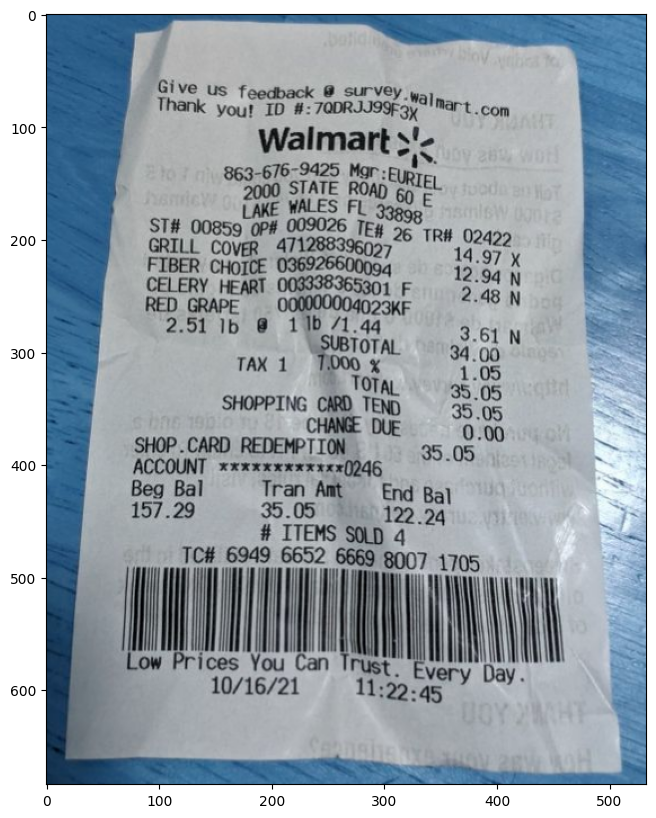

In [420]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

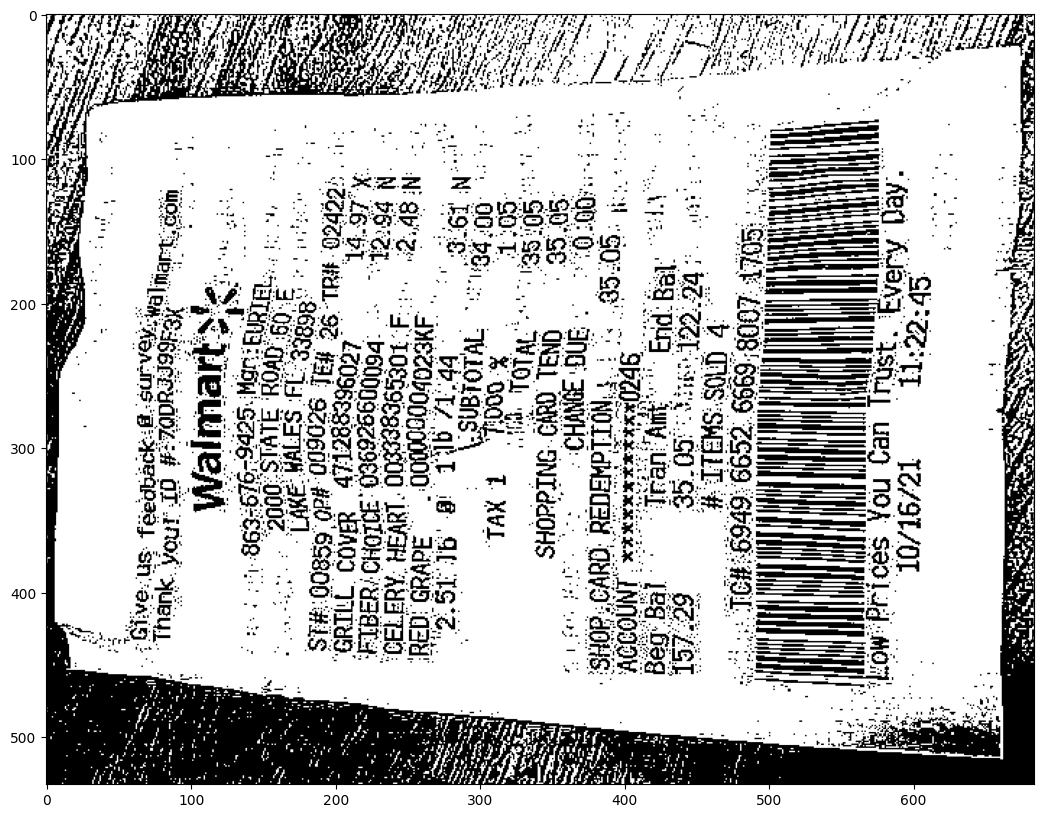

In [421]:
def bw_scanner(image)-> MatLike:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(gray, -1, sharpen_kernel)
    thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return cv2.bitwise_not(thresh)
result = bw_scanner(scanned)
minval = np.percentile(result, 4.5)
maxval = np.percentile(result, 95)
pixvals = np.clip(result, minval, maxval)
pixvals = ((pixvals - minval) / (maxval - minval)) * 255
result = np.rot90(pixvals.astype(np.uint8),1)
plot_rgb(result)
